In [1]:
import Bio.SeqIO as SeqIO
from tqdm import tqdm
import itertools 
import random

def count_kmers(read, k):
    """Count kmer occurrences in a given read.

    Parameters
    ----------
    read : string
        A single DNA sequence.
    k : int
        The value of k for which to count kmers.

    Returns
    -------
    counts : dictionary, {'string': int}
        A dictionary of counts keyed by their individual kmers (strings
        of length k).

    Examples
    --------
    >>> count_kmers("GATGAT", 3)
    {'ATG': 1, 'GAT': 2, 'TGA': 1}
    """
    # Start with an empty dictionary
    counts = {}
    nucleotides = ['A', 'T', 'G', 'C']
    # Add the kmer to the dictionary if it's not there
    for i in itertools.product(nucleotides, repeat=k):
        counts["".join(i)] = 0
    # Calculate how many kmers of length k there are
    num_kmers = len(read) - k + 1
    # Loop over the kmer start positions
    for kmer in window(read, n=k):
        kmer = "".join(kmer)
        if kmer not in counts:
            continue
        # Increment the count for this kmer
        counts[kmer] += 1
    # Return the final counts
    return counts

from math import sqrt

from numpy import (array, unravel_index, nditer, linalg, random, subtract,
                   power, exp, pi, zeros, arange, outer, meshgrid, dot)
from collections import defaultdict
from warnings import warn


def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.

    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return sqrt(dot(x, x.T))


class Som:
    def __init__(self,x,y,input_len,sigma=1.0,learning_rate=0.5,random_seed=None):
        """
            Initializes a Self Organizing Maps.
            x,y - dimensions of the SOM
            input_len - number of the elements of the vectors in input
            sigma - spread of the neighborhood function (Gaussian), needs to be adequate to the dimensions of the map.
            (at the iteration t we have sigma(t) = sigma / (1 + t/T) where T is #num_iteration/2)
            learning_rate - initial learning rate
            (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
            random_seed, random seed to use.
        """
        if sigma >= x/2.0 or sigma >= y/2.0:
            warn('Warning: sigma is too high for the dimension of the map.')
        if random_seed:
            self.random_generator = random.RandomState(random_seed)
        else:
            self.random_generator = random.RandomState(random_seed)
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = self.random_generator.rand(x,y,input_len)*2-1 # random initialization
        self.weights = array([v/linalg.norm(v) for v in self.weights]) # normalization
        self.activation_map = zeros((x,y))
        self.neigx = arange(x)
        self.neigy = arange(y) # used to evaluate the neighborhood function
        self.neighborhood = self.gaussian

    def _activate(self,x):
        """ Updates matrix activation_map, in this matrix the element i,j is the response of the neuron i,j to x """
        s = subtract(x,self.weights) # x - w
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.activation_map[it.multi_index] = fast_norm(s[it.multi_index]) # || x - w ||
            it.iternext()

    def activate(self,x):
        """ Returns the activation map to x """
        self._activate(x)
        return self.activation_map

    def gaussian(self,c,sigma):
        """ Returns a Gaussian centered in c """
        d = 2*pi*sigma*sigma
        ax = exp(-power(self.neigx-c[0],2)/d)
        ay = exp(-power(self.neigy-c[1],2)/d)
        return outer(ax,ay) # the external product gives a matrix

    def diff_gaussian(self,c,sigma):
        """ Mexican hat centered in c (unused) """
        xx,yy = meshgrid(self.neigx,self.neigy)
        p = power(xx-c[0],2) + power(yy-c[1],2)
        d = 2*pi*sigma*sigma
        return exp(-(p)/d)*(1-2/d*p)

    def winner(self,x):
        """ Computes the coordinates of the winning neuron for the sample x """
        self._activate(x)
        return unravel_index(self.activation_map.argmin(),self.activation_map.shape)

    def update(self,x,win,t):
        """
            Updates the weights of the neurons.
            x - current pattern to learn
            win - position of the winning neuron for x (array or tuple).
            t - iteration index
        """
        # eta(t) = eta(0) / (1 + t/T) 
        # keeps the learning rate nearly constant for the first T iterations and then adjusts it
        eta = self.learning_rate/(1+t/self.T)
        sig = self.sigma/(1+t/self.T) # sigma and learning rate decrease with the same rule
        g = self.neighborhood(win,sig)*eta # improves the performances
        it = nditer(g, flags=['multi_index'])
        while not it.finished:
            # eta * neighborhood_function * (x-w)
            self.weights[it.multi_index] += g[it.multi_index]*(x-self.weights[it.multi_index])            
            # normalization
            self.weights[it.multi_index] = self.weights[it.multi_index] / fast_norm(self.weights[it.multi_index])
            it.iternext()

    def quantization(self,data):
        """ Assigns a code book (weights vector of the winning neuron) to each sample in data. """
        q = zeros(data.shape)
        for i,x in enumerate(data):
            q[i] = self.weights[self.winner(x)]
        return q


    def random_weights_init(self,data):
        """ Initializes the weights of the SOM picking random samples from data """
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] = data[int(self.random_generator.rand()*len(data)-1)]
            self.weights[it.multi_index] = self.weights[it.multi_index]/fast_norm(self.weights[it.multi_index])
            it.iternext()

    def train_random(self,data,num_iteration):        
        """ Trains the SOM picking samples at random from data """
        self._init_T(num_iteration)        
        for iteration in range(num_iteration):
            rand_i = int(round(self.random_generator.rand()*len(data)-1)) # pick a random sample
            self.update(data[rand_i],self.winner(data[rand_i]),iteration)

    def train_batch(self,data,num_iteration):
        """ Trains using all the vectors in data sequentially """
        self._init_T(len(data)*num_iteration)
        iteration = 0
        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx],self.winner(data[idx]),iteration)
            iteration += 1

    def _init_T(self,num_iteration):
        """ Initializes the parameter T needed to adjust the learning rate """
        self.T = num_iteration/2 # keeps the learning rate nearly constant for the first half of the iterations

    def distance_map(self):
        """ Returns the average distance map of the weights.
            (Each mean is normalized in order to sum up to 1) """
        um = zeros((self.weights.shape[0],self.weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1,it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1,it.multi_index[1]+2):
                    if ii >= 0 and ii < self.weights.shape[0] and jj >= 0 and jj < self.weights.shape[1]:
                        um[it.multi_index] += fast_norm(self.weights[ii,jj,:]-self.weights[it.multi_index])
            it.iternext()
        um = um/um.max()
        return um

    def activation_response(self,data):
        """ 
            Returns a matrix where the element i,j is the number of times
            that the neuron i,j have been winner.
        """
        a = zeros((self.weights.shape[0],self.weights.shape[1]))
        for x in data:
            a[self.winner(x)] += 1
        return a

    def quantization_error(self,data):
        """ 
            Returns the quantization error computed as the average distance between
            each input sample and its best matching unit.            
        """
        error = 0
        for x in data:
            error += fast_norm(x-self.weights[self.winner(x)])
        return error/len(data)

    def win_map(self,data):
        """
            Returns a dictionary wm where wm[(i,j)] is a list with all the patterns
            that have been mapped in the position i,j.
        """
        winmap = defaultdict(list)
        for x in data:
            winmap[self.winner(x)].append(x)
        return winmap

### unit tests
from numpy.testing import assert_almost_equal, assert_array_almost_equal, assert_array_equal

class TestSom:
    def setup_method(self, method):
        self.som = Som(5,5,1)
        for w in self.som.weights: # checking weights normalization
            assert_almost_equal(1.0,linalg.norm(w))
        self.som.weights = zeros((5,5)) # fake weights
        self.som.weights[2,3] = 5.0
        self.som.weights[1,1] = 2.0

    def test_fast_norm(self):
        assert fast_norm(array([1,3])) == sqrt(1+9)

    def test_gaussian(self):
        bell = self.som.gaussian((2,2),1)
        assert bell.max() == 1.0
        assert bell.argmax() == 12  # unravel(12) = (2,2)

    def test_win_map(self):
        winners = self.som.win_map([5.0,2.0])
        assert winners[(2,3)][0] == 5.0
        assert winners[(1,1)][0] == 2.0

    def test_activation_reponse(self):
        response = self.som.activation_response([5.0,2.0])
        assert response[2,3] == 1
        assert response[1,1] == 1

    def test_activate(self):
        assert self.som.activate(5.0).argmin() == 13.0  # unravel(13) = (2,3)
     
    def test_quantization_error(self):
        self.som.quantization_error([5,2]) == 0.0
        self.som.quantization_error([4,1]) == 0.5

    def test_quantization(self):
        q = self.som.quantization(array([4,2]))
        assert q[0] == 5.0
        assert q[1] == 2.0

    def test_random_seed(self):
        som1 = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        som2 = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        assert_array_almost_equal(som1.weights,som2.weights) # same initialization
        data = random.rand(100,2)
        som1 = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        som1.train_random(data,10)
        som2 = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        som2.train_random(data,10)
        assert_array_almost_equal(som1.weights,som2.weights) # same state after training

    def test_train_batch(self):
        som = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        data = array([[4,2],[3,1]])
        q1 = som.quantization_error(data)
        som.train_batch(data,10)
        assert q1 > som.quantization_error(data)

    def test_train_random(self):
        som = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        data = array([[4,2],[3,1]])
        q1 = som.quantization_error(data)
        som.train_random(data,10)
        assert q1 > som.quantization_error(data)

    def test_random_weights_init(self):
        som = Som(2,2,2,random_seed=1)
        som.random_weights_init(array([[1.0,.0]]))
        for w in som.weights:
            assert_array_equal(w[0],array([1.0,.0]))

import itertools
def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(itertools.islice(it, n))
    if len(result) == n:
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [2]:
def dict2array(d):
    return list(d.values())

In [3]:
def longest_key(d):
    return sorted([(len(v), k) for k, v in d.items()])[-1][1]

In [15]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [27]:
L = 1000
K = 4
data_ctg = {}
ctg_index = {}
data = {}

with open("./ecoli23.fna", "r") as f:
    for record in tqdm(SeqIO.parse(f, "fasta")):
        data_ctg[record.id] = str(record.seq).upper()
        for i, p in enumerate(range(1, len(record.seq)//L, L)):
            data[(record.id, i)] = str(record.seq).upper()[p:p+L]
            if record.id not in ctg_index.keys(): ctg_index[record.id] = []
            ctg_index[record.id].append(i)

7it [00:00, 27.01it/s]


In [28]:
kmer_datas = {}
for k, v in tqdm(data.items()):
    kmer_data = list(count_kmers(v, K).values())
    assert len(kmer_data) == 4**K
    if k not in kmer_datas.keys(): kmer_datas[k] = []
    kmer_datas[k] += kmer_data

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 2430.94it/s]


In [29]:
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(dict2array(kmer_datas))
cnt = 1
som = Som(2, 2, 4**K, sigma=.001,learning_rate=1e-5)
while som.distance_map().T.min() > 0.9:
    print(f"{cnt} trial")
    som = Som(2, 2, 4**K, sigma=.001,learning_rate=1e-5)
    #som = Som(2, 1, 4**K, sigma=.001,learning_rate=0.5)
    som.random_weights_init(X)

    som.train_random(X, 10000)
    #som.train_batch(X, 10000)
    cnt+=1
print(som.distance_map().T)

change = {(0,0) : 1, (0,1): -1, (1,0): 1j, (1,1): -1j}

length = [-1]
for i in list(map(len, ctg_index.values())):
    length.append(i + length[-1])
del length[0]

print(length)
raw_spec = {}
for i, k in enumerate(data_ctg.keys()):
    if k not in raw_spec.keys(): raw_spec[k] = []
    if length[-1] == length[i]:
        for g in X[length[i]:]:
            raw_spec[k] += [change[som.winner(i)] for i in g]
        continue
    #print(np.shape(X[length[i]: length[i+1] + 1]))
    for g in X[length[i]: length[i+1] + 1]:
        raw_spec[k] += [change[som.winner(i)] for i in g]

1 trial
2 trial
3 trial
[[0.93753864 1.        ]
 [0.88702258 0.93863811]]
[0, 1, 2, 3, 13, 23, 33]


In [37]:
import pywt

#random.seed(101)
lkey = longest_key(raw_spec) #random.choice(len(raw_spec))
ctg1 = np.asarray(list(raw_spec[lkey]))

cnt = 0
M = 100
best_list = [lkey]
ctg = 0
while True:
    cnt +=1
    ma1 = 0
    ma2 = 0
    for k, v in raw_spec.items():
        if k in best_list: continue
        #print(ctg1)
        #print("++++++++++++++++++++++++++++++++++")
        #print(ctg)
        #print(ctg1.shape)
        ctg = np.concatenate([ctg1, np.asarray(v)])
        cwtmatr, freqs = pywt.cwt(np.asarray(ctg), list(range(1, M)), 'cmor4-1.0')
        if ma1 < np.absolute(np.max(cwtmatr)):
            ma1 = np.absolute(np.max(cwtmatr))
            best1 = (ma1, cwtmatr, k, v)
        
        ctg = np.concatenate([np.asarray(v), ctg1])
        cwtmatr, freqs = pywt.cwt(np.asarray(ctg), list(range(1, M)), 'cmor4-1.0')
        if ma2 < np.absolute(np.max(cwtmatr)):
            ma2 = np.absolute(np.max(cwtmatr))
            best2 = (ma2, cwtmatr, k, v)

    if best1[0] < best2[0]:
        ctg1 = np.concatenate([np.asarray(best2[3]),ctg1])
        best_list.insert(0, best2[2])
        #last = np.asarray(best2[3]
        #print(ctg1.shape)

    else:
        ctg1 = np.concatenate([ctg1, np.asarray(best1[3])])
        best_list.append(best1[2])
        #last = np.asarray(best1[3])
    
    print(best_list)
    if len(best_list) >= len(raw_spec):
        break
    
    #print(cnt)
    if cnt % 10 == 0:
        print(cnt // 10)

['ecolidouble1_1', 'ecolidouble2']
['ecolidouble1_1', 'ecolidouble2', 'ecolidouble1_2']
['ecolidouble1_1', 'ecolidouble2', 'ecolidouble1_2', 'ecolidouble1_5']
['ecolidouble1_1', 'ecolidouble2', 'ecolidouble1_2', 'ecolidouble1_5', 'ecolidouble3']
['ecolibouble1_3', 'ecolidouble1_1', 'ecolidouble2', 'ecolidouble1_2', 'ecolidouble1_5', 'ecolidouble3']
['ecolibouble1_3', 'ecolidouble1_1', 'ecolidouble2', 'ecolidouble1_2', 'ecolidouble1_5', 'ecolidouble3', 'ecolidouble1_4']


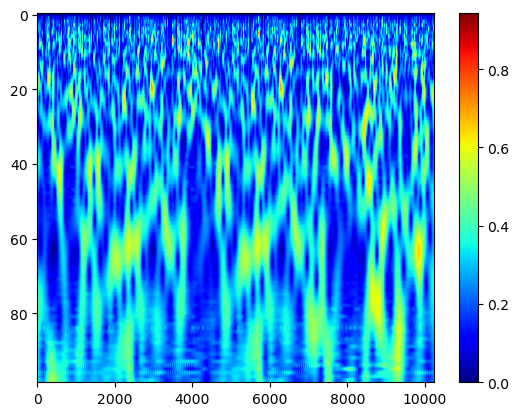

In [38]:
import matplotlib.pyplot as plt
R = 100
cwtmatr, freqs = pywt.cwt(np.asarray(ctg1), list(range(1, R)), 'cmor4-1.0')
plt.imshow(np.absolute(cwtmatr),  cmap='jet', aspect='auto',vmax=np.absolute(cwtmatr).max(), vmin=0)
plt.colorbar()
plt.show()
#plt.savefig("./temptemp.jpg")

In [53]:
len(ctg1)

512